In [1]:
import sqlite3

import pandas as pd

db_conn = sqlite3.connect('/home/orestis/code/Orestis/InvestorAPI/app/database/ibd.db')

In [11]:
query = "SELECT * FROM stocks_with_sector"
df = pd.read_sql(query, db_conn)
df.rename(columns={'price_change_pct': 'price_value_change'}, inplace=True)
df.to_csv('ibd_dataset.csv')

In [15]:
df

,comp_rating,eps_rating,rs_rating,acc_dis_rating,fifty_two_wk_high,name,symbol,closing_price,price_value_change,vol_chg_pct,smr_rating,sector_name,sector_daily_price_change_pct,sector_start_of_year_price_change_pct,registered_date,registered_date_ts
0,97,99,97,B,22.1,ComstckRes,CRK,18.90,-0.34,-76.0,A,ENERGY,0.4,49.23,25-11-2022,1669327200
1,97,99,95,B,73.8,Matador,MTDR,66.54,-0.20,-82.0,A,ENERGY,0.4,49.23,25-11-2022,1669327200
2,95,81,97,B,36.5,Brigham Minrls,MNRL,35.29,0.16,-66.0,A,ENERGY,0.4,49.23,25-11-2022,1669327200
3,91,80,93,B-,64.2,Cactus A,WHD,52.89,-0.79,-62.0,A,ENERGY,0.4,49.23,25-11-2022,1669327200
4,97,91,98,A-,32.4,ShoalsTech,SHLS,31.03,0.15,-73.0,..,ENERGY,0.4,49.23,25-11-2022,1669327200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175501,66,88,59,B,70.9,MolsonCoorsB,TAP,61.80,-1.25,206.0,C,ALCOHL/TOB,-1.2,-24.38,15-12-2023,1702591200
175502,42,79,32,C-,105.0,PhillipMrris,PM,94.46,-0.21,270.0,..,ALCOHL/TOB,-1.2,-24.38,15-12-2023,1702591200
175503,70,86,71,C+,26.3,Turning Point,TPB,24.45,-0.37,71.0,B,ALCOHL/TOB,-1.2,-24.38,15-12-2023,1702591200
175504,75,54,89,A+,NaN,Universal,UVV,63.32,-0.10,999.0,C,ALCOHL/TOB,-1.2,-24.38,15-12-2023,1702591200


In [3]:
df.columns

Index(['comp_rating', 'eps_rating', 'rs_rating', 'acc_dis_rating',
       'fifty_two_wk_high', 'name', 'symbol', 'closing_price',
       'price_value_change', 'vol_chg_pct', 'smr_rating', 'sector_name',
       'sector_daily_price_change_pct',
       'sector_start_of_year_price_change_pct', 'registered_date',
       'registered_date_ts'],
      dtype='object')

In [12]:
# Convert 'registered_date' to datetime
df['registered_date'] = pd.to_datetime(df['registered_date'], format='%d-%m-%Y')

# Sort the DataFrame based on 'symbol' and 'registered_date'
df.sort_values(by=['symbol', 'registered_date'], inplace=True)

# Replace invalid values
df['smr_rating'].replace('..', pd.NA, inplace=True)
df['acc_dis_rating'].replace('..', pd.NA, inplace=True)
# Fill NaN values with the last available value within each symbol group
df['smr_rating'] = df.groupby('symbol')['smr_rating'].transform(lambda x: x.ffill().bfill())
df['acc_dis_rating'] = df.groupby('symbol')['acc_dis_rating'].transform(lambda x: x.ffill().bfill())

df['closing_price_after_1_w'] = df.groupby('symbol')['closing_price'].shift(-1)
df['closing_price_before_1_w'] = df.groupby('symbol')['closing_price'].shift(1)
df.dropna(inplace=True)
# Calculate the percentage change
df['price_pct_change_after_1_w'] = ((df['closing_price_after_1_w'] - df['closing_price']) / df['closing_price']) * 100
df['price_pct_change_1_w'] = ((df['closing_price'] - df['closing_price_before_1_w']) / df['closing_price_before_1_w']) * 100

df['eps_rating_change'] = df.groupby('symbol')['eps_rating'].diff()
df['comp_rating_change'] = df.groupby('symbol')['comp_rating'].diff()
df['rs_rating_change'] = df.groupby('symbol')['rs_rating'].diff()
df['fifty_two_wk_high_pct_change'] = df.groupby('symbol')['fifty_two_wk_high'].pct_change() * 100

# Create categorical target column
bins = [-float('inf'), 0, float('inf')]
labels = ['down', 'up']

df['price_pct_change_after_1_w_range'] = pd.cut(
    df['price_pct_change_after_1_w'],
    bins=bins,
    labels=labels,
    right=False
)

df.drop([
    'comp_rating',
    'eps_rating',
    'rs_rating',
    'name',
    'symbol',
    'fifty_two_wk_high',
    'price_value_change',
    'registered_date_ts',
    'closing_price_after_1_w',
    'closing_price_before_1_w',
    'closing_price',
    'price_pct_change_after_1_w'
], axis=1, inplace=True)

df = df.dropna()
# Reset index if needed
df.reset_index(drop=True, inplace=True)


In [13]:
df

,acc_dis_rating,vol_chg_pct,smr_rating,sector_name,sector_daily_price_change_pct,sector_start_of_year_price_change_pct,registered_date,price_pct_change_1_w,eps_rating_change,comp_rating_change,rs_rating_change,fifty_two_wk_high_pct_change,price_pct_change_after_1_w_range
0,A,-40.0,A,MEDICAL,1.4,-13.36,2022-08-12,0.000000,0.0,-3.0,-12.0,0.0,up
1,A-,-3.0,A,MEDICAL,-0.3,-14.95,2022-08-19,2.994012,2.0,6.0,2.0,0.0,down
2,A-,-22.0,A,MEDICAL,-3.1,-17.64,2022-08-26,-5.595930,0.0,-7.0,-7.0,0.0,down
3,B+,18.0,A,MEDICAL,-1.2,-18.95,2022-09-02,-1.462664,0.0,-2.0,4.0,0.0,up
4,B+,75.0,A,MEDICAL,0.6,-15.29,2022-09-09,7.500000,0.0,11.0,16.0,0.0,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144522,C-,55.0,B,MEDICAL,1.2,-4.45,2023-03-31,9.190173,0.0,2.0,1.0,0.0,up
144523,B,-26.0,B,MEDICAL,0.4,-3.57,2023-04-06,1.333333,0.0,5.0,2.0,0.0,down
144524,B+,-62.0,B,MEDICAL,-0.5,-1.94,2023-04-14,-1.809211,0.0,-1.0,-4.0,0.0,up
144525,B+,-49.0,B,MEDICAL,1.5,-0.58,2023-04-21,0.167504,0.0,1.0,2.0,0.0,down


In [7]:
df['sector_name'].value_counts()

MEDICAL       17349
BANKS         13504
ENERGY        12735
FINANCE       11804
SOFTWARE      10940
RETAIL         9075
BUSINS SVC     8052
BUILDING       6084
MACHINE        5291
INSURNCE       4582
LEISURE        4497
UTILITY        4408
CHIPS          3796
TRANSPRT       3665
FOOD/BEV       3368
CONSUMER       3297
TELECOM        2806
MISC           2803
ELECTRNCS      2761
CHEMICAL       2710
AUTO           2404
METALS         2192
REAL EST       2130
AEROSPACE      1941
MINING         1726
INTERNET       1628
MEDIA          1559
COMPUTER       1551
APPAREL        1414
AGRICULTRE     1138
S&Ls           1103
ALCOHL/TOB      868
OFFICE          228
Name: sector_name, dtype: int64

In [8]:
df['smr_rating'].value_counts()

B    56640
A    40391
C    35105
D    15446
E     5827
Name: smr_rating, dtype: int64

In [9]:
df['acc_dis_rating'].value_counts()

B-    24479
B     20877
B+    15079
D-    12644
C+    12450
C     11831
E     11157
C-    11094
D+     9975
A-     8916
D      8578
A      4275
A+     2054
Name: acc_dis_rating, dtype: int64

In [14]:
df['price_pct_change_after_1_w_range'].value_counts()

up      74026
down    70501
Name: price_pct_change_after_1_w_range, dtype: int64

In [15]:
dataset = df.sort_values(by='registered_date').copy()

In [18]:
dataset

,acc_dis_rating,vol_chg_pct,smr_rating,sector_name,sector_daily_price_change_pct,sector_start_of_year_price_change_pct,registered_date,eps_rating_change,comp_rating_change,rs_rating_change,fifty_two_wk_high_pct_change,price_pct_change_after_1_w_range
0,A,-57.0,A,MEDICAL,1.0,-15.48,2022-08-05,0.0,-1.0,-6.0,0.000000,-5 to 0
76832,D,10.0,A,ELECTRNCS,-0.5,-26.55,2022-08-05,-1.0,-13.0,-37.0,0.000000,-10-
19531,D-,-36.0,A,BANKS,0.8,-15.64,2022-08-05,1.0,-9.0,-8.0,0.000000,-5 to -10
76912,C+,-37.0,C,BUILDING,0.0,-27.51,2022-08-05,7.0,-3.0,-12.0,-5.714286,-10-
76967,B,-35.0,A,MEDICAL,1.0,-15.48,2022-08-05,1.0,5.0,10.0,0.000000,-5 to 0
...,...,...,...,...,...,...,...,...,...,...,...,...
112549,D,-40.0,A,INSURNCE,0.3,4.01,2023-11-17,0.0,-2.0,-10.0,0.000000,-5 to -10
75116,A-,-27.0,C,AEROSPACE,-0.9,11.30,2023-11-17,0.0,0.0,1.0,5.555556,5 to 10
118685,C+,-39.0,B,MEDICAL,0.0,-9.40,2023-11-17,0.0,0.0,2.0,0.000000,0 to 5
30012,A-,-45.0,A,RETAIL,0.1,11.54,2023-11-17,1.0,0.0,-2.0,0.137931,5 to 10


# Split to train and test set

In [16]:
import datetime as dt

cutoff_date = dt.datetime(2023, 11, 1)
train_set = dataset[dataset['registered_date'] < cutoff_date].copy()
test_set = dataset[dataset['registered_date'] >= cutoff_date].copy()
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [17]:
cols_to_drop = ['registered_date', 'price_pct_change_after_1_w_range']
target_col = 'price_pct_change_after_1_w_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

Overall Accuracy: 47.39%


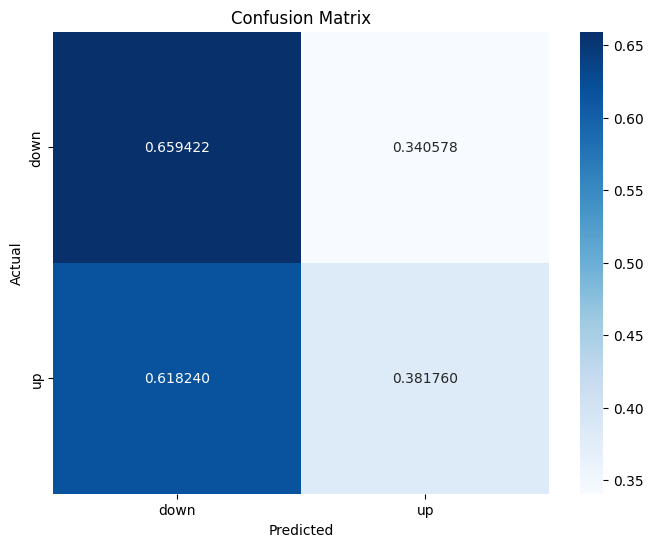

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
)

categorical_columns = ['acc_dis_rating' ,'smr_rating', 'sector_name']
column_transformer = make_column_transformer(
    (
        OneHotEncoder(), categorical_columns
    ),
    remainder='passthrough'
)

random_forrest_classifier = RandomForestClassifier(n_estimators=100)
random_forrest = make_pipeline(
    column_transformer,
    random_forrest_classifier
)

random_forrest.fit(X_train, y_train)
y_pred_random_forrest = random_forrest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_random_forrest)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_random_forrest, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Overall Accuracy: 50.31%


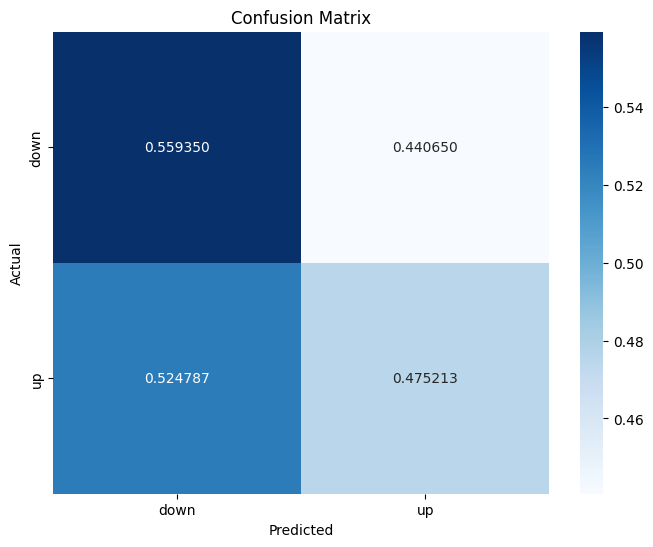

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.neighbors import KNeighborsClassifier

categorical_columns = ['acc_dis_rating' ,'smr_rating', 'sector_name']
column_transformer = make_column_transformer(
    (
        OneHotEncoder(), categorical_columns
    ),
    remainder='passthrough'
)

knn_classifier = make_pipeline(
    column_transformer,
    KNeighborsClassifier(weights='distance', n_neighbors=5)
)

knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Overall Accuracy: 56.61%


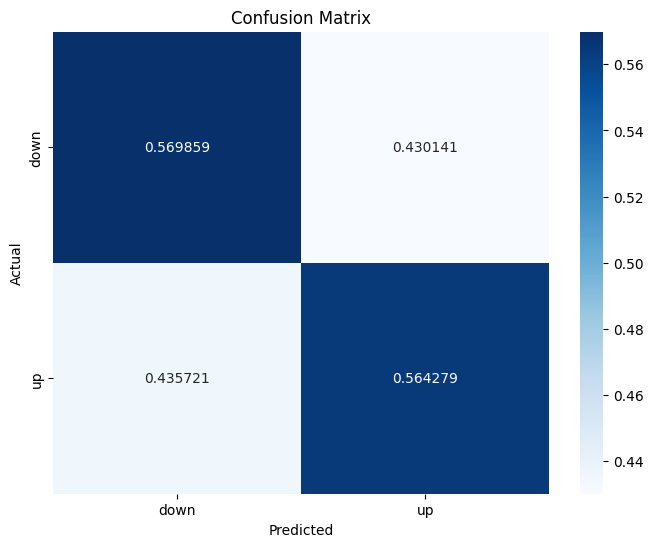

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.svm import SVC

categorical_columns = ['acc_dis_rating' ,'smr_rating', 'sector_name']
column_transformer = make_column_transformer(
    (
        OneHotEncoder(), categorical_columns
    ),
    remainder='passthrough'
)

lr_classifier = make_pipeline(
    column_transformer,
    SVC()
)

lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()